In [1]:
import sys
import os
sys.path.append("..")

from glob import glob
import matplotlib.pyplot as plt
import ipywidgets as ipw
import numpy as np 
from tqdm.notebook import tqdm
# from communicative_agent import CommunicativeAgent
from imitative_agent import ImitativeAgent
from lib.dataset_wrapper import Dataset
from lib import utils
from lib import abx_utils

current path: /mnt/c/Users/vpaul/OneDrive - CentraleSupelec/Inner_Speech/agent/temp_repo/imitative_agent


In [2]:
ABX_NB_SAMPLES = 50
AGENT_ABX_DISTANCES = [
    #     {
    #     "sound_units": {
    #         "metric": "cosine",
    #         "weight": 1,
    #     }
    # },
    {
        "art_estimated": {
            "metric": "euclidean",
            "weight": 1,
        },
    }
]

In [3]:
agents_path = glob("../out/imitative_agent_0jerk/*/")
agents_path.sort()

print(f"Found {len(agents_path)} agents")

# Dictionary to store agent aliases mapped to their paths
agents_alias = {}

for agent_path in agents_path:
    # Load agent configuration without neural networks for efficiency
    agent = ImitativeAgent.reload(agent_path, load_nn=False)
    config = agent.config

    # Get agent identifier from path
    agent_i = agent_path[-2]

    # Handle nb_derivatives, always equal to 0 in our implementation
    try:
        nb_derivatives = config['model']['direct_model']['nb_derivatives']
    except:
        nb_derivatives = 0
        

    # Create descriptive alias string containing key agent parameters
    agent_alias = " ".join((
        f"{','.join(config['dataset']['names'])}", # Dataset names
        f"synth_art={agent.synthesizer.config['dataset']['art_type']}", # Synthesizer art type
        f"nd={nb_derivatives}", # Number of derivatives
        f"jerk_c={config['training']['jerk_loss_ceil']}",
        f"jerk_w={config['training']['jerk_loss_weight']}", # Jerk loss weight
        f"bi={config['model']['inverse_model']['bidirectional']}",
        f"({agent_i})", # Agent indentifier
    ))
    

    # Print agent information    
    print(f"\nAgent {agent_i}:")
    print(f"- Path: {agent_path}")
    print(f"- Datasets: {config['dataset']['names']}")
    print(f"- Synthesizer art type: {agent.synthesizer.config['dataset']['art_type']}")
    print(f"- Jerk loss weight: {config['training']['jerk_loss_weight']}")
    
    # Store mapping between alias and path
    agents_alias[agent_alias] = agent_path

Found 0 agents


In [4]:
# Load saved ABX matrices from disk or initialize empty dict
agents_abx_matrices = utils.pickle_load("../out/imitative_agent/abx_cache.pickle", {})
print(f"Loaded {len(agents_abx_matrices)} saved ABX matrices")

for agent_alias, agent_path in tqdm(agents_alias.items()):
    print(f"\nProcessing agent: {agent_alias}")

    try:
        # Load agent and get dataset info
        agent = ImitativeAgent.reload(agent_path)
        main_dataset = agent.get_main_dataset()
        
        # Skip if dataset is not pb2007
        if 'pb2007' not in main_dataset.name:
            print(f"Skipping agent with dataset {main_dataset.name}")
            continue
            
        agent_lab = agent.get_datasplit_lab(2) # Get test split labels
        agent_features = agent.repeat_datasplit(2) # Get test split features

        # Get phoneme information
        consonants = main_dataset.phones_infos["consonants"]
        vowels = main_dataset.phones_infos["vowels"]

        # Get indices of consonants in dataset
        consonants_indexes = abx_utils.get_datasets_phones_indexes(agent_lab, consonants, vowels)
        
        # Initialize ABX matrices for this agent if not already saved
        if agent_path not in agents_abx_matrices:
            agents_abx_matrices[agent_path] = {}
        agent_abx_matrices = agents_abx_matrices[agent_path]
        
        # Calculate ABX matrices for each distance metric
        for distance in AGENT_ABX_DISTANCES:
            distance_signature = abx_utils.get_distance_signature(distance)
            if distance_signature in agent_abx_matrices: 
                continue
            print(f"Computing ABX matrix for {distance_signature}")
            abx_matrix = abx_utils.get_abx_matrix(consonants, consonants_indexes, agent_features, distance, ABX_NB_SAMPLES)

            # Save the computed matrix        
            agent_abx_matrices[distance_signature] = abx_matrix
            utils.pickle_dump("../out/imitative_agent/abx_cache.pickle", agents_abx_matrices)
            print(f"Saved ABX matrix for {distance_signature}")
            
    except KeyError as e:
        print(f"Skipping agent due to KeyError: {e}")
        continue


Loaded 0 saved ABX matrices


0it [00:00, ?it/s]


Analyzing ABX scores for distance metric: art_estimated x1 (euclidean)


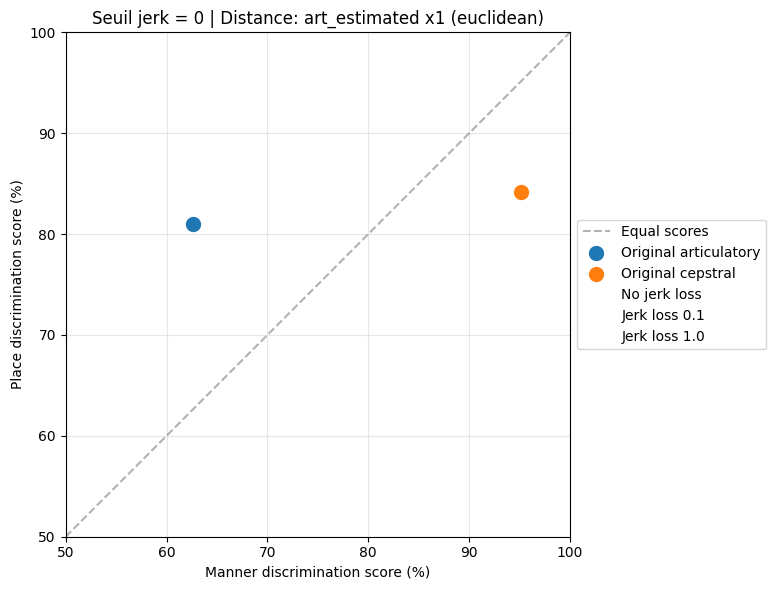

In [5]:
CEIL = 0

# # plosives + fricatives
# abx_art_params = {'manner': 62.73333333333334, 'place': 80.25}
# abx_cepstrum = {'manner': 95.3, 'place': 73.75}
# Fricatives only scores
abx_art_params = {'manner': 62.63333333333333, 'place': 81.0}
abx_cepstrum = {'manner': 95.1, 'place': 84.16666666666667}

for distance in AGENT_ABX_DISTANCES:
    distance_signature = abx_utils.get_distance_signature(distance)
    print(f"\nAnalyzing ABX scores for distance metric: {distance_signature}")

    plt.figure(figsize=(8, 6))
    ax = plt.subplot(aspect="equal")
    ax.set_xlim(50, 100)
    ax.set_ylim(50, 100)
    ax.set_xlabel("Manner discrimination score (%)")
    ax.set_ylabel("Place discrimination score (%)")
    ax.set_title(f"Seuil jerk = {CEIL} | Distance: {distance_signature}")

    ax.plot([50, 100], [50, 100], 'k--', alpha=0.3, label='Equal scores')

    # Plot human baselines
    ax.scatter(abx_art_params["manner"], abx_art_params["place"],
               c="tab:blue", label="Original articulatory", s=100)
    ax.scatter(abx_cepstrum["manner"], abx_cepstrum["place"],
               c="tab:orange", label="Original cepstral", s=100)

    # Track which labels have been used
    plotted_labels = set()

    for agent_alias, agent_path in agents_alias.items():
        agent = ImitativeAgent.reload(agent_path, load_nn=False)
        dataset = agent.get_main_dataset()

        if agent.config["training"]["jerk_loss_ceil"] != CEIL:
            continue
        if agent.config["model"]["inverse_model"]["bidirectional"]:
            continue

        jerk_weight = agent.config["training"]["jerk_loss_weight"]
        if jerk_weight == 0:
            color = "tab:red"
            label = "No jerk loss"
        elif jerk_weight == 0.1:
            color = "tab:pink"
            label = "Jerk loss 0.1"
        elif jerk_weight == 1:
            color = "tab:green"
            label = "Jerk loss 1.0"
        else:
            continue  # skip unknown jerk weights

        agent_abx_matrix = agents_abx_matrices[agent_path][distance_signature]

        consonant_groups = dataset.phones_infos["consonant_groups"].copy()
        consonant_groups["place"] = [['f', 's', 's^'], ['v', 'z', 'z^']]

        # Define or import consonants
        # Example: consonants = dataset.phones_infos["consonants"]
        agent_groups_score = abx_utils.get_groups_score(consonants, agent_abx_matrix, consonant_groups)

        print(f"\nAgent: {agent_alias}")
        print(f"Manner discrimination: {agent_groups_score['manner']:.1f}%")
        print(f"Place discrimination: {agent_groups_score['place']:.1f}%")

        # Only label once per jerk_weight group
        if label not in plotted_labels:
            ax.scatter(agent_groups_score["manner"], agent_groups_score["place"],
                       c=color, label=label, s=100)
            plotted_labels.add(label)
        else:
            ax.scatter(agent_groups_score["manner"], agent_groups_score["place"],
                       c=color, s=100)

    # Ensure all jerk weight labels are always visible
    dummy_legend_points = {
        "No jerk loss": ("tab:red", 0),
        "Jerk loss 0.1": ("tab:pink", 0),
        "Jerk loss 1.0": ("tab:green", 0),
    }
    for label, (color, y_dummy) in dummy_legend_points.items():
        if label not in plotted_labels:
            ax.scatter(0, y_dummy, c=color, label=label, alpha=0)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


{'dataset': {'batch_size': 8, 'datasplits_size': [64, 16, 20], 'names': ['pb2007'], 'num_workers': 6, 'shuffle_between_epochs': True, 'sound_type': 'cepstrum'}, 'model': {'direct_model': {'activation': 'relu', 'batch_norm': True, 'dropout_p': 0.25, 'hidden_layers': [256, 256, 256, 256]}, 'inverse_model': {'bidirectional': True, 'dropout_p': 0.25, 'hidden_size': 32, 'num_layers': 2}}, 'synthesizer': {'name': 'ea587b76c95fecef01cfd16c7f5f289d-0/'}, 'training': {'jerk_loss_ceil': 0, 'jerk_loss_weight': 0, 'learning_rate': 0.001, 'max_epochs': 500, 'patience': 25}}
{'direct_model': {'activation': 'relu', 'batch_norm': True, 'dropout_p': 0.25, 'hidden_layers': [256, 256, 256, 256]}, 'inverse_model': {'bidirectional': True, 'dropout_p': 0.25, 'hidden_size': 32, 'num_layers': 2}}
{'direct_model': {'activation': 'relu', 'batch_norm': True, 'dropout_p': 0.25, 'hidden_layers': [256, 256, 256, 256]}, 'inverse_model': {'bidirectional': True, 'dropout_p': 0.25, 'hidden_size': 32, 'num_layers': 2}}


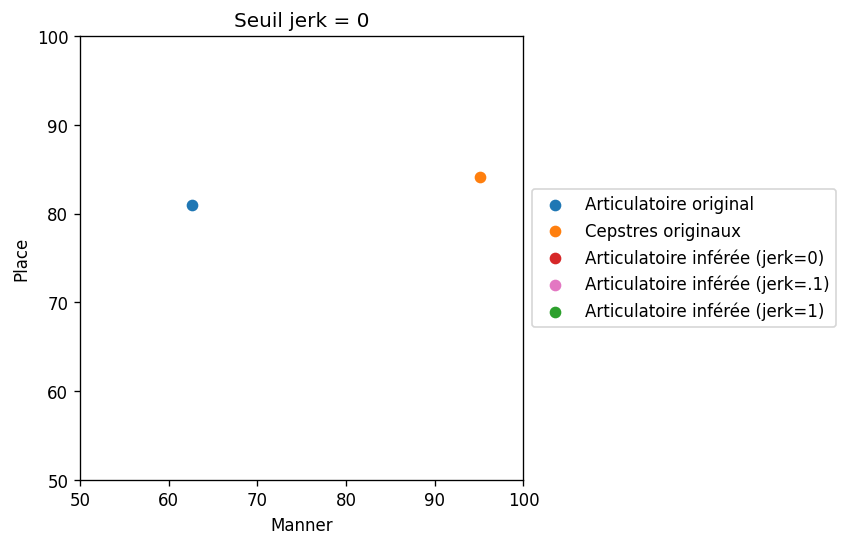

In [ ]:
# Original code from imitative-agent

CEIL = 0

# # plosives + fricatives
# abx_art_params = {'manner': 62.73333333333334, 'place': 80.25}
# abx_cepstrum = {'manner': 95.3, 'place': 73.75}
# fricatives only
abx_art_params = {'manner': 62.63333333333333, 'place': 81.0}
abx_cepstrum = {'manner': 95.1, 'place': 84.16666666666667}

for distance in AGENT_ABX_DISTANCES:
    distance_signature = abx_utils.get_distance_signature(distance)
    
    plt.figure(dpi=120)
    ax = plt.subplot(aspect="equal")
    ax.set_xlim(50, 100)
    ax.set_ylim(50, 100)
    ax.set_xlabel("Manner")
    ax.set_ylabel("Place")
    
    ax.set_title("Seuil jerk = %s" % CEIL)
    
    ax.scatter(abx_art_params["manner"], abx_art_params["place"], c="tab:blue", label="Articulatoire original")
    ax.scatter(abx_cepstrum["manner"], abx_cepstrum["place"], c="tab:orange", label="Cepstres originaux")
    
    ax.scatter(0, 0, c="tab:red", label="Articulatoire inférée (jerk=0)")
    ax.scatter(0, 0, c="tab:pink", label="Articulatoire inférée (jerk=.1)")
    ax.scatter(0, 0, c="tab:green", label="Articulatoire inférée (jerk=1)")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    for agent_alias, agent_path in agents_alias.items():
        agent = ImitativeAgent.reload(agent_path, load_nn=False)
        dataset = agent.get_main_dataset()
        
        color = "tab:red"
        if agent.config["training"]["jerk_loss_weight"] == .1:
            color = "tab:pink"
        if agent.config["training"]["jerk_loss_weight"] == 1:
            color = "tab:green"
        if agent.config["model"]["inverse_model"]["bidirectional"] == True:
            color = "tab:cyan"
            continue
        if agent.config["training"]["jerk_loss_ceil"] != CEIL:
            continue

        agent_abx_matrix = agents_abx_matrices[agent_path][distance_signature]
        
        consonant_groups = dataset.phones_infos["consonant_groups"].copy()
        # consonant_groups["manner"] = [['f', 'v', 'm'], ['s', 'z', 'n'], ['s^', 'z^', 'r']]
        consonant_groups["place"] = [['f', 's', 's^'], ['v', 'z', 'z^']]
        # consonant_groups["place"] = [['p', 't', 'k'], ['b', 'd', 'g']]
        
        agent_groups_score = abx_utils.get_groups_score(consonants, agent_abx_matrix, consonant_groups)
        ax.scatter(agent_groups_score["manner"], agent_groups_score["place"], c=color)
    
    plt.show()